In [5]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from lib.SamplingOptimizer import SamplingOptimizer
from lib.RangeOptimizer import RangeOptimizer
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared
from matplotlib import pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(precision = 2)
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
# x1 ∈ [-5, 10], x2 ∈ [0, 15]
def brannin_hoo(x, e_std=0.01):
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    e = np.random.normal(0, e_std)
        
    return np.log((x[1] - b * x[0] ** 2 + c * x[0] - r) ** 2 + s * (1 - t) * np.cos(x[0]) + s + e)

brannin_hoo(np.array(np.random.uniform((-5,0),(10,15))), e_std=0.1)

3.1947596282630437

Best achieved in this run: 2.3780292360616397
Best achieved in this run: 2.0390328073253765
Best achieved in this run: 0.9833294557531567
Best achieved in this run: 1.1081614106284752
Best achieved in this run: 1.6587576793779961
Best achieved in this run: 2.483800453120851
Best achieved in this run: 2.0958265068511674
Best achieved in this run: 1.8484257254752257
Best achieved in this run: 0.40236375270266866
Best achieved in this run: 2.026848991269312
Best achieved in this run: 2.6683545921394063
Best achieved in this run: 0.6904740569109922
Best achieved in this run: 1.0652115555351114
Best achieved in this run: 0.6167598277758366
Best achieved in this run: 0.45310538284738855
Best achieved in this run: 1.023008624530128
Best achieved in this run: 0.8026558076572168
Best achieved in this run: 1.4462358056450646
Best achieved in this run: 6.724397472620489
Best achieved in this run: 1.6313997239111628
Best achieved in this run: 0.4736079761362383
Best achieved in this run: 0.8536976

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Best achieved in this run: 1.755783207832645
Best achieved in this run: 3.493600176748371
Best achieved in this run: 1.0162625327977846
Best achieved in this run: 0.682978539680799
Best achieved in this run: 1.2040296206081014
Best achieved in this run: 3.774779501748836
Best achieved in this run: 1.706353273829461


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


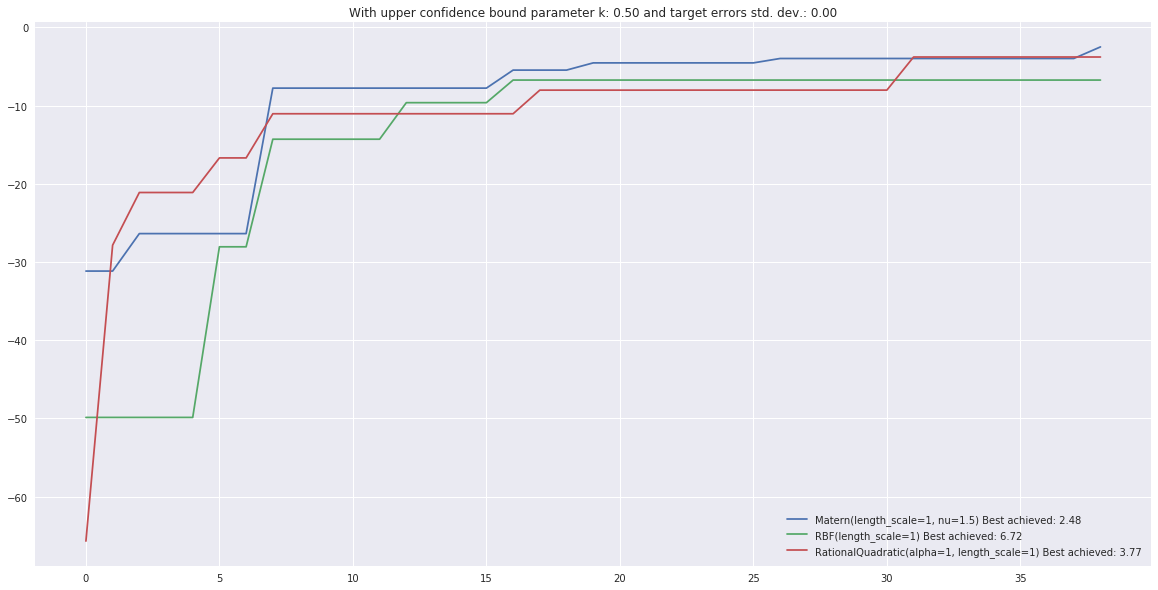

Best achieved in this run: 2.3354935647414465
Best achieved in this run: 0.9093694106495268
Best achieved in this run: 0.9780829778964275
Best achieved in this run: 0.9637187777394604
Best achieved in this run: 0.9708670040908589
Best achieved in this run: 1.164567432470673
Best achieved in this run: 0.3536131184826704
Best achieved in this run: 2.174908954530404
Best achieved in this run: 2.1066179128864153
Best achieved in this run: 0.5427855279270875
Best achieved in this run: 0.74156552237238
Best achieved in this run: 0.6895506219489295
Best achieved in this run: 1.1088206590144718
Best achieved in this run: 3.240013550443777
Best achieved in this run: 0.5530439669937527
Best achieved in this run: 0.9700730995025197
Best achieved in this run: 1.776135620290254
Best achieved in this run: 0.5535278669469467
Best achieved in this run: 0.6428125984720863
Best achieved in this run: 1.4091532639449913
Best achieved in this run: 7.9752620840607715
Best achieved in this run: 1.02405277822

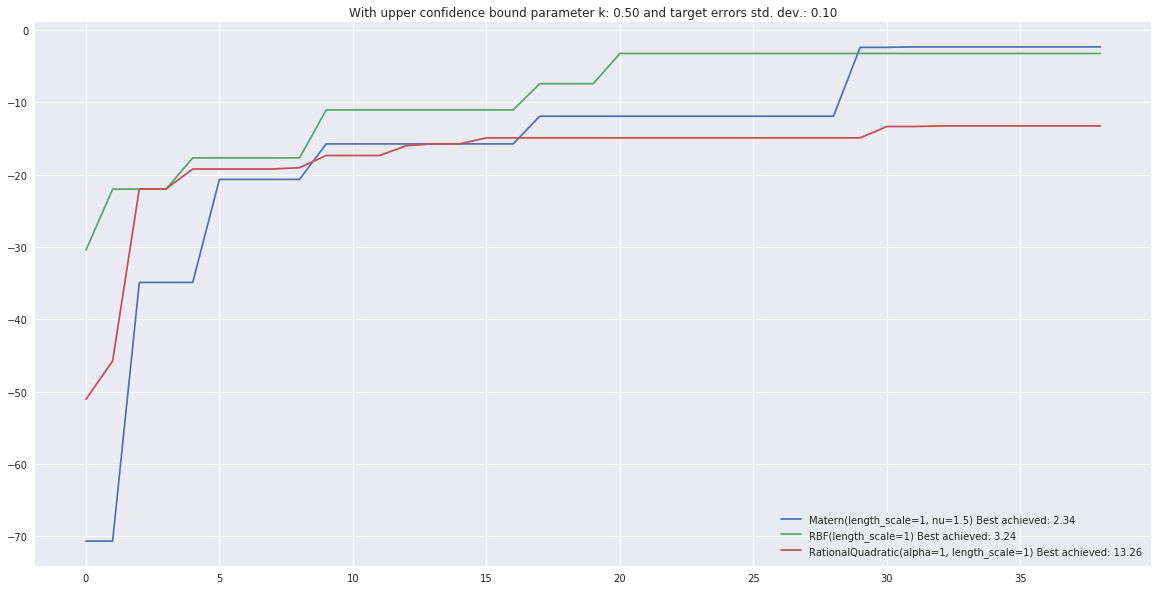

Best achieved in this run: 1.160442944789658
Best achieved in this run: 0.6357667537701039
Best achieved in this run: 3.5154623605647757
Best achieved in this run: 1.4054054369818414
Best achieved in this run: 1.5896611464517976
Best achieved in this run: 2.7628839523693514
Best achieved in this run: 1.784018710292859
Best achieved in this run: 0.4998249709959032
Best achieved in this run: 1.9459850042973919
Best achieved in this run: 1.6869941222872424
Best achieved in this run: 0.7272465683296765
Best achieved in this run: 1.2559738887594578
Best achieved in this run: 1.0119879268887917
Best achieved in this run: 3.8391571635855506
Best achieved in this run: 2.887725765348724
Best achieved in this run: 0.7943337270330327
Best achieved in this run: 0.8010378977236281
Best achieved in this run: 3.1316772330815685
Best achieved in this run: 0.49670453374826357
Best achieved in this run: 0.49309870460089295
Best achieved in this run: 2.1698876656295814
Best achieved in this run: 6.286556

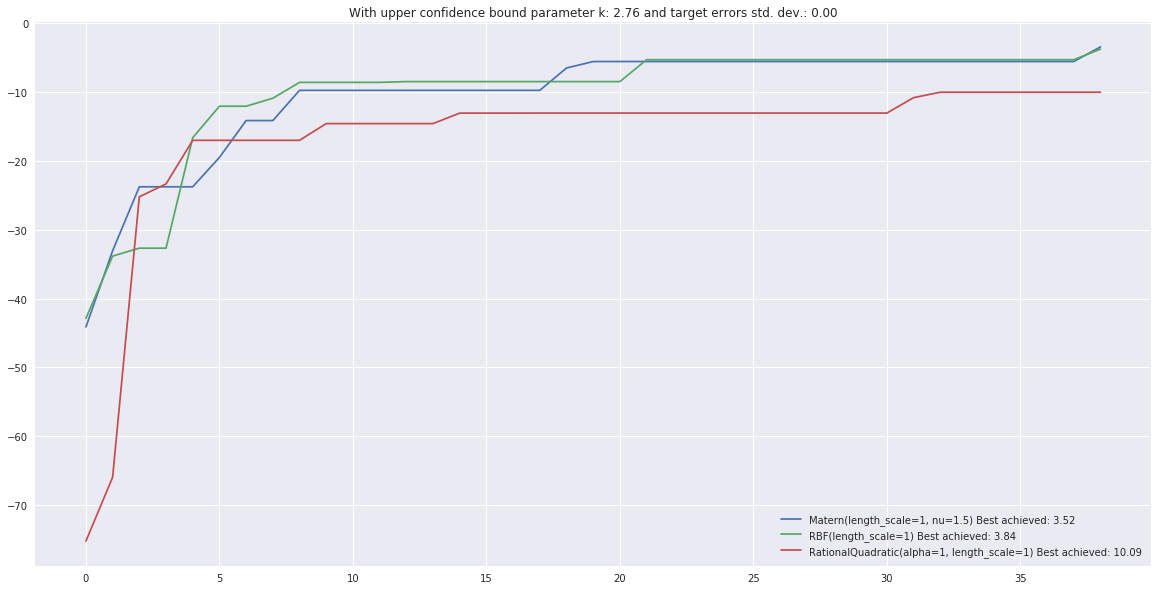

Best achieved in this run: 3.857077601472242
Best achieved in this run: 0.6155307808465036
Best achieved in this run: 1.8083288500710342
Best achieved in this run: 0.8556885176762494
Best achieved in this run: 0.5844934302308479
Best achieved in this run: 1.7193176446583003
Best achieved in this run: 0.8580359717277887
Best achieved in this run: 1.8300165913585902
Best achieved in this run: 1.7359149794255926
Best achieved in this run: 1.5987005945404194
Best achieved in this run: 0.6436431762205078
Best achieved in this run: 0.8727341241707215
Best achieved in this run: 1.8109850428724483
Best achieved in this run: 0.8026941555626989
Best achieved in this run: 1.155979356122346
Best achieved in this run: 1.2887189944580473
Best achieved in this run: 0.5503191317720987
Best achieved in this run: 1.2731149866465048
Best achieved in this run: 0.44474753300065517
Best achieved in this run: 0.5858481401414868
Best achieved in this run: 0.5224983508025031
Best achieved in this run: 1.531340

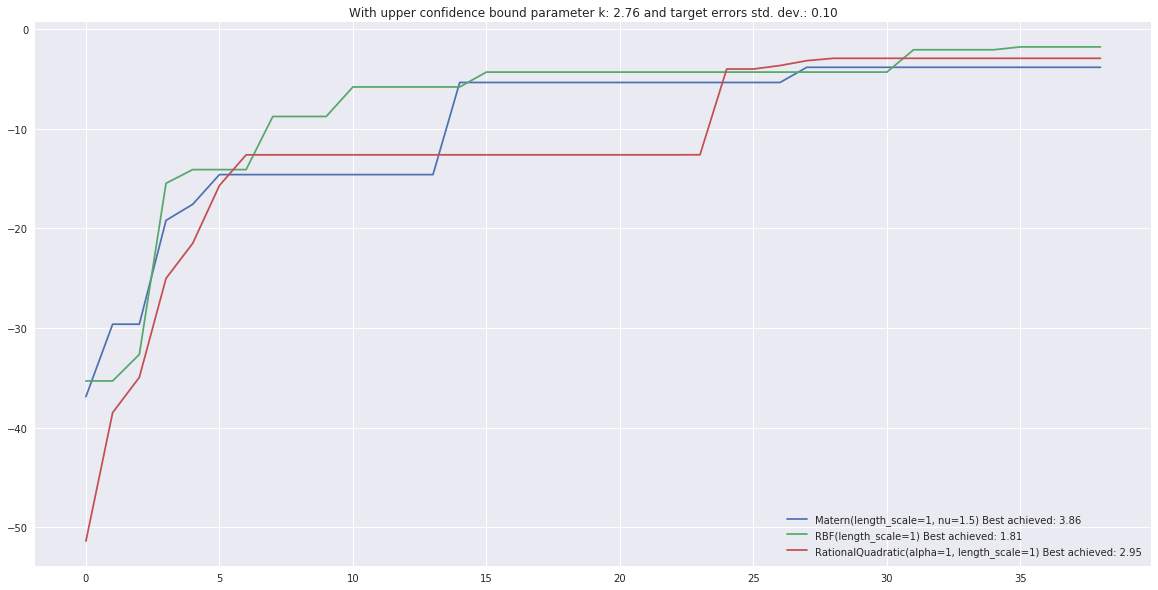

In [9]:
for k in [.5, 2.756]:
    for e in [.0011, .1]:
        results = []
        for i, kernel in enumerate([Matern(), RBF(), RationalQuadratic()]):
            all_scores = []
            for r in range(10):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(40):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print('Best achieved in this run: {}'.format(-ro.best_achieved[-1]))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

Best achieved in this run: 1.4304499841924152
Best achieved in this run: 1.5004200102625174
Best achieved in this run: 0.4787055070458946
Best achieved in this run: 2.0153237648032034
Best achieved in this run: 1.7630349968918357
Best achieved in this run: 0.8722075519532007
Best achieved in this run: 2.089828691262028
Best achieved in this run: 0.6955261563432402
Best achieved in this run: 0.9981599809822598
Best achieved in this run: 0.4674192388191465
Best achieved in this run: 1.3968102541614222
Best achieved in this run: 0.4435653904187326
Best achieved in this run: 0.8320831740149202
Best achieved in this run: 0.7962165769413885
Best achieved in this run: 1.2825467996685551
Best achieved in this run: 1.922424770538752
Best achieved in this run: 0.7726403783909307
Best achieved in this run: 0.8736706436963951
Best achieved in this run: 3.3189424142355337
Best achieved in this run: 1.88776138195997


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Best achieved in this run: 0.9038568775085193
Best achieved in this run: 0.7221295018802186
Best achieved in this run: 12.175304517311215
Best achieved in this run: 2.3831673756952405
Best achieved in this run: 2.810632794757078
Best achieved in this run: 0.4777591184408677
Best achieved in this run: 2.291232184304218
Best achieved in this run: 3.3618587571986276
Best achieved in this run: 2.1397194507040607
Best achieved in this run: 0.5381524100513992


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


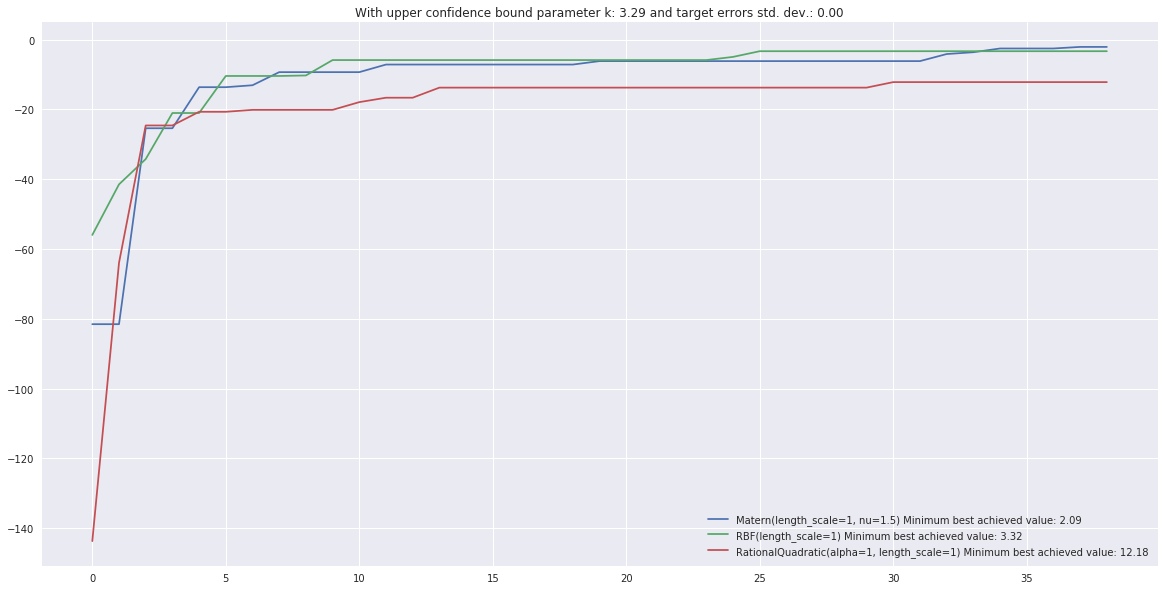

Best achieved in this run: 2.0490646479334047
Best achieved in this run: 5.504109273485512
Best achieved in this run: 2.4248669540419083
Best achieved in this run: 1.9831511805117232
Best achieved in this run: 0.9077867157725799
Best achieved in this run: 1.8178767289279605
Best achieved in this run: 1.2628825938709658
Best achieved in this run: 1.9740295336996299
Best achieved in this run: 2.4741087887498314
Best achieved in this run: 0.9157579025815872
Best achieved in this run: 0.5858592546978254
Best achieved in this run: 1.4479876490585428
Best achieved in this run: 0.28724853097529557
Best achieved in this run: 2.4929130341351335
Best achieved in this run: 1.3764915958251107
Best achieved in this run: 1.711598834920579
Best achieved in this run: 0.4663697551252949
Best achieved in this run: 0.650637944319029
Best achieved in this run: 0.9280625564020736
Best achieved in this run: 0.7383425076795912
Best achieved in this run: 0.8843838140081433
Best achieved in this run: 0.9624569

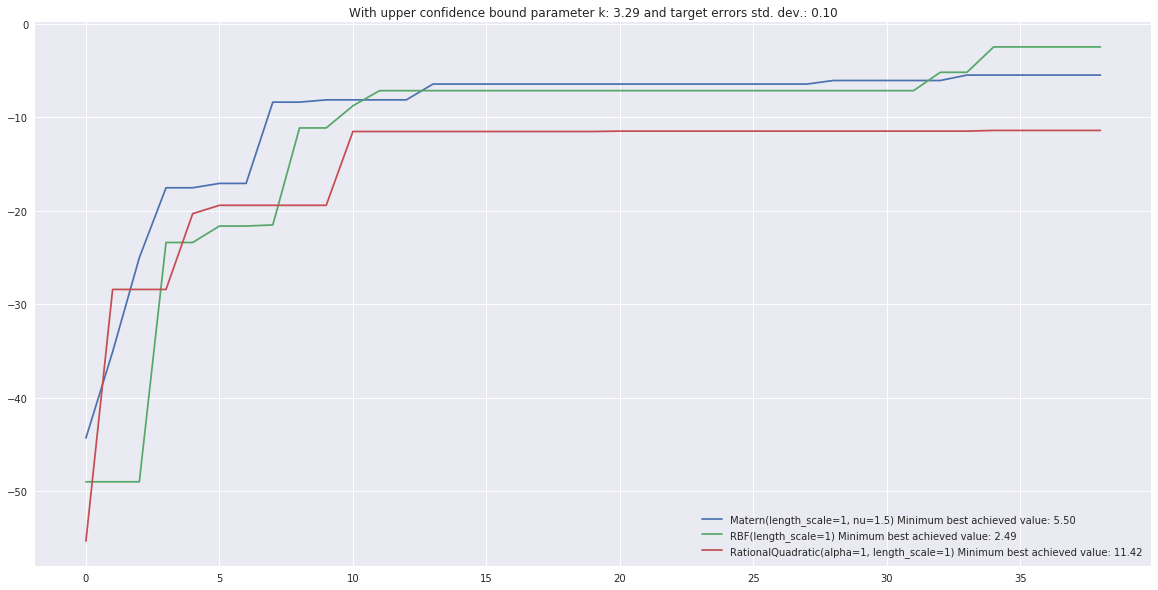

In [10]:
for k in [3.291]:
    for e in [.0001, .1]:
        results = []
        for i, kernel in enumerate([Matern(), RBF(), RationalQuadratic()]):
            all_scores = []
            for r in range(10):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(40):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print('Best achieved in this run: {}'.format(-ro.best_achieved[-1]))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Best achieved in this run: 0.41540743544699377
Best achieved in this run: 0.4561244585146594
Best achieved in this run: 0.4051322269170473
Best achieved in this run: 0.4631105932125251
Best achieved in this run: 0.618640634478371
Best achieved in this run: 0.4596598110826912
Best achieved in this run: 0.5652226468109903
Best achieved in this run: 2.261077686986933
Best achieved in this run: 0.8242265632577261
Best achieved in this run: 0.4057950527167875
Best achieved in this run: 2.0167000329259746
Best achieved in this run: 1.9657851892568647
Best achieved in this run: 0.5925675970427612
Best achieved in this run: 1.3233162397570934
Best achieved in this run: 1.4980189014356693
Best achieved in this run: 1.552889607099692
Best achieved in this run: 1.339793826465108
Best achieved in this run: 1.3102201637399207
Best achieved in this run: 1.83860600205484
Best achieved in this run: 0.9151472351252626


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


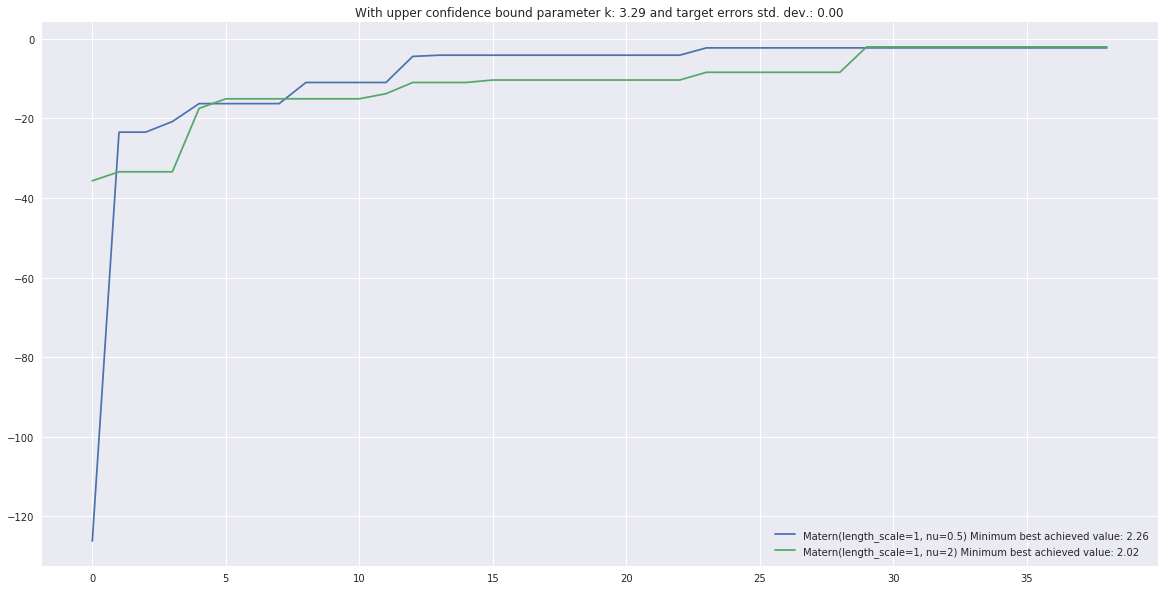

Best achieved in this run: 0.8457881847709727
Best achieved in this run: 0.47746941829617157
Best achieved in this run: 0.2769621772573857
Best achieved in this run: 0.486225927088972
Best achieved in this run: 0.812829797795658
Best achieved in this run: 0.7527736691398396
Best achieved in this run: 1.2039349406485105
Best achieved in this run: 1.713817954169238
Best achieved in this run: 0.7631975058460035
Best achieved in this run: 0.49354076122681356
Best achieved in this run: 3.6392289651220775
Best achieved in this run: 0.44387302193201117
Best achieved in this run: 0.6137286391769797
Best achieved in this run: 0.9991174573102638
Best achieved in this run: 1.543193445710986
Best achieved in this run: 2.563739058664362
Best achieved in this run: 1.646733251814277
Best achieved in this run: 2.2279947009420176
Best achieved in this run: 1.9635555996569938
Best achieved in this run: 2.1636398549257865


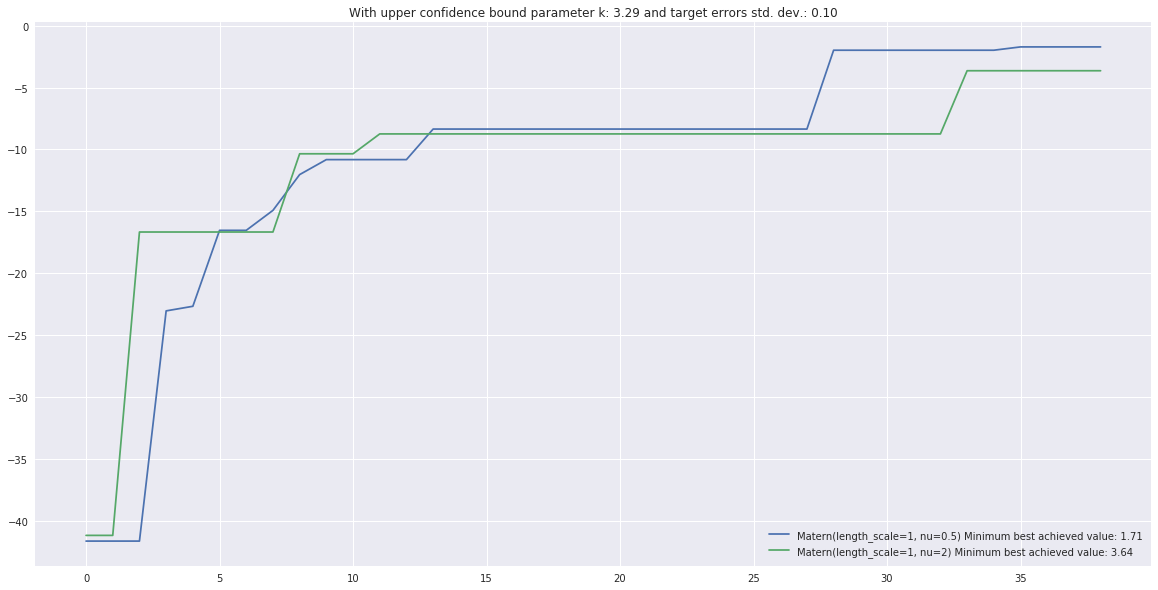

In [12]:
for k in [3.291]:
    for e in [.0001, .1]:
        results = []
        for i, kernel in enumerate([Matern(nu=.5), Matern(nu=2)]):
            all_scores = []
            for r in range(10):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(40):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print('Best achieved in this run: {}'.format(-ro.best_achieved[-1]))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

In [259]:
for k in [3.291]:
    for e in [.0001, .1]:
        results = []
        for i, kernel in enumerate([Matern(nu=.5), Matern(nu=2.), RBF(), RationalQuadratic()]):
            all_scores = []
            for r in range(10):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [1, 2, brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(100):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print('Best achieved in this run: {}'.format(-ro.best_achieved[-1]))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], -np.max(r[0][1:])))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


KeyboardInterrupt: 

## Ensembling Kernels

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


Best achieved: 0.9133642640273165 Log Likelihood: -47.872412696088375
Best achieved: 0.9036704820963753 Log Likelihood: -66.1535088599228
Best achieved: 0.916786070868234 Log Likelihood: -56.442901121360876
Best achieved: 0.9104099958510065 Log Likelihood: -51.660702987105694
Best achieved: 0.8875864936857718 Log Likelihood: -61.56732969872074
Best achieved: 0.9167013447960977 Log Likelihood: -49.09335344518243
Best achieved: 0.8407357741944904 Log Likelihood: -52.09940811024698
Best achieved: 0.8949731638289948 Log Likelihood: -55.41404643220827
Best achieved: 0.897569124419614 Log Likelihood: -58.005311829538655
Best achieved: 0.8951656883884136 Log Likelihood: -55.064205453563005
Best achieved: 0.5462287149364837 Log Likelihood: -149.96248551701532
Best achieved: 0.8314344120227025 Log Likelihood: -143.7900573142109
Best achieved: 0.7234015663443996 Log Likelihood: -130.24419094044467


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.49e-05]), 'funcalls': 50, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 4}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


Best achieved: 0.6949392972848669 Log Likelihood: -94.97439967935239
Best achieved: 0.8424065600956424 Log Likelihood: -136.2143044259886
Best achieved: 0.7637401290241687 Log Likelihood: -138.26957001554274
Best achieved: 0.8601416088196575 Log Likelihood: -143.46795682598147
Best achieved: 0.18580317763546764 Log Likelihood: -109.4347157335663
Best achieved: 0.8631575123752573 Log Likelihood: -150.7551420156619
Best achieved: 0.8430413574743756 Log Likelihood: -140.06678257745105
Best achieved: -0.22570604143241266 Log Likelihood: -149.307842674319
Best achieved: 0.4458950189955472 Log Likelihood: -154.57968599452826
Best achieved: 0.4674356577439173 Log Likelihood: -153.9047243833489
Best achieved: 0.4995594928448303 Log Likelihood: -161.7695735619928
Best achieved: 0.05675115642423072 Log Likelihood: -154.2765492787113
Best achieved: 0.4883206740501861 Log Likelihood: -163.5139007626127
Best achieved: 0.2541949066445143 Log Likelihood: -173.87073243738251
Best achieved: 0.403824650

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -9.72e-05]), 'funcalls': 55, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 4}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -3.55e-05]), 'funcalls': 56, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 4}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ -7.74e-05]), 'funcalls': 54, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 5}
  " state: %s" % convergence_dict)
/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally wi

Best achieved: -0.671860673374673 Log Likelihood: -127.04940702471015
Best achieved: 0.01179301293718113 Log Likelihood: -193.96612262029834
Best achieved: 0.4605443804113267 Log Likelihood: -205.7707203368661
Best achieved: -0.6668324082093762 Log Likelihood: -117.94690144191426
Best achieved: 0.45037794980803314 Log Likelihood: -195.33518585459916
Best achieved: 0.5729020740276325 Log Likelihood: -191.32127840808343
Best achieved: 0.34218985698248594 Log Likelihood: -173.5579140096308
Best achieved: 0.9205207350449094 Log Likelihood: -37.61520444809575


/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  3.16e-05,   2.56e-05]), 'funcalls': 57, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'warnflag': 2, 'nit': 12}
  " state: %s" % convergence_dict)


Best achieved: 0.9037795105203658 Log Likelihood: -54.609390652806866
Best achieved: 0.8641008145070233 Log Likelihood: -48.88652450253173
Best achieved: 0.9183331448890952 Log Likelihood: -32.38622919816517
Best achieved: 0.8569218103315489 Log Likelihood: -39.18445556153334
Best achieved: 0.9181366619617537 Log Likelihood: -31.7912165378888
Best achieved: 0.9116487810277574 Log Likelihood: -43.24990199090193
Best achieved: 0.9134276858273538 Log Likelihood: -23.596781721701262
Best achieved: 0.9239005858320051 Log Likelihood: -27.5398551497371
Best achieved: 0.9165018888558781 Log Likelihood: -33.01902065512707


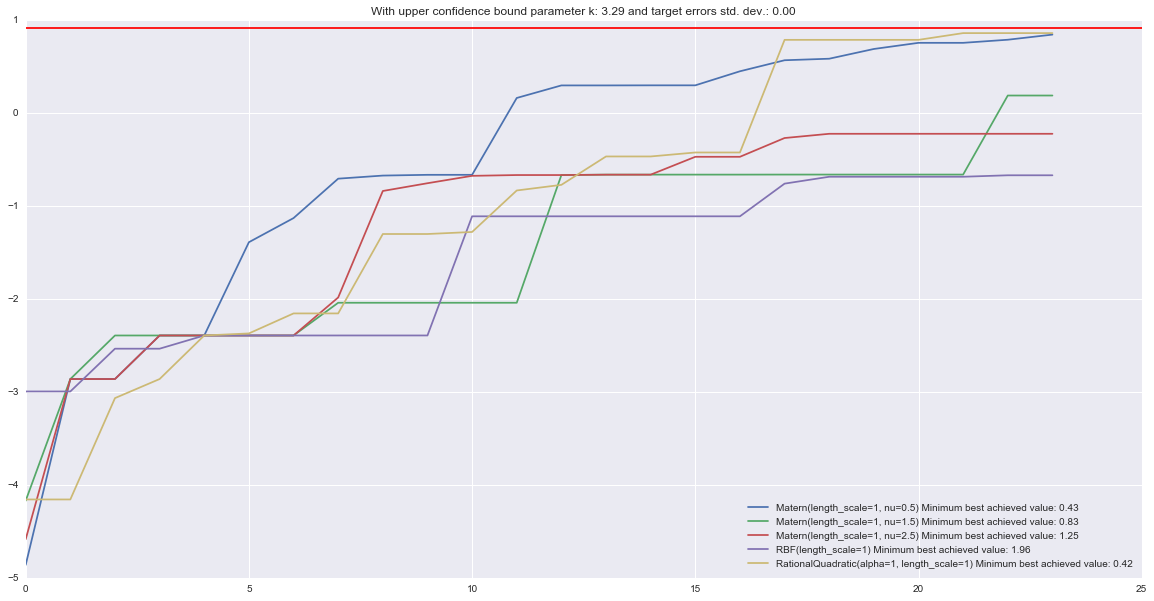

In [290]:
for k in [3.291]:
    for e in [.001]:
        results = []
#         for i, kernel in enumerate([Matern(nu=1/2)]):
        for i, kernel in enumerate([Matern(nu=1/2), Matern(nu=3/2), Matern(nu=5/2), RBF(), RationalQuadratic()]):
            all_scores = []
            for r in range(10):
                ro = RangeOptimizer({
                    'x1': (-5., 10.),
                    'x2': (0., 15.)
                }, kernel=kernel, init_observations=[
                    [1, 2, - brannin_hoo(np.array([1, 2]), e_std=0.1)],
                    [0, 0, - brannin_hoo(np.array([0, 0]), e_std=0.1)]
                ], acquisition_params={
                    'k': k,
                    'type': 'upper_confidence_bound'
                })
                for t in range(25):
                    x = ro.suggest(return_dict=True)
                    y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
                    ro.update([x[fn] for fn in ro.feature_names], y)
                    
                print('Best achieved: {} Log Likelihood: {}'.format(
                    ro.best_achieved[-1],
                    ro.model.log_marginal_likelihood_value_
                ))
                all_scores.append(ro.best_achieved)
                
            avg_scores = np.stack(all_scores, axis=1).min(axis=1)
            results.append((avg_scores,str(kernel)))

        plt.figure(figsize=(20,10))
        for i, r in enumerate(results):
            plt.plot(r[0][1:], label='{} Minimum best achieved value: {:.2f}'.format(r[1], np.exp(-np.max(r[0][1:]))))

        plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
        plt.legend(loc=4)
        plt.axhline(- brannin_hoo([9.42478, 2.475]), c='r')
        plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


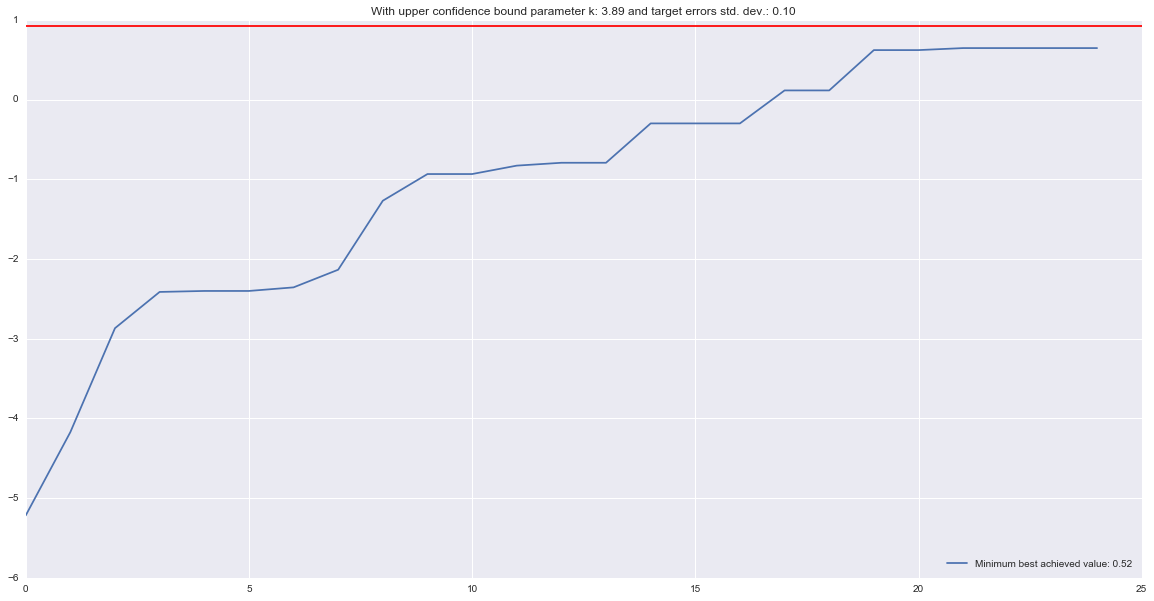

In [316]:
e = .1
k = 3.89
opts = []
all_results = []
for r in range(10):
    results = []
    opts = []
    for kernel in [Matern(nu=1/2), Matern(nu=3/2), Matern(nu=5/2), RBF(), RationalQuadratic()]:
        ro = RangeOptimizer({
            'x1': (-5., 10.),
            'x2': (0., 15.)
        }, kernel=kernel, init_observations=[
            [1, 2, - brannin_hoo(np.array([1, 2]), e_std=e)],
            [0, 0, - brannin_hoo(np.array([0, 0]), e_std=e)]
        ], acquisition_params={
            'k': k,
            'type': 'upper_confidence_bound'
        })
        opts.append(ro)
        
    for t in range(25):
        if t > 5:
            lls = [ro.model.log_marginal_likelihood_value_ for ro in opts]
            best_opt_index = np.argmax(lls)
            x = opts[best_opt_index].suggest(return_dict=True)
        else:
            x = np.random.choice(opts).suggest(return_dict=True)
            
        y = - brannin_hoo([x['x1'], x['x2']], e_std=e) # negative to turn mimization into maximization
        results.append(y)
        [ro.update([x[fn] for fn in ro.feature_names], y) for ro in opts]
        results[-1] = np.max([y, np.max(results)])
        
    all_results.append(results)
    
min_results = np.stack(all_results, axis=1).min(axis=1)

plt.figure(figsize=(20,10))
plt.plot(min_results, label='Minimum best achieved value: {:.2f}'.format(np.exp(-np.max(min_results[1:]))))
plt.title('With upper confidence bound parameter k: {:.2f} and target errors std. dev.: {:.2f}'.format(k, e))
plt.legend(loc=4)
plt.axhline(- brannin_hoo([9.42478, 2.475]), c='r')
plt.show()